# u/v plots for overview

---

In [1]:
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

import mitequinox.utils as ut
import mitequinox.plot as pl

In [2]:
if False:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=2, cores=2)
    w = cluster.scale(jobs=10)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---

# load data


In [34]:
def load_UV(dij=8, 
            time="2012-01-01 00:00:00",
            face=None,
           ):

    ds = ut.load_data(["SSU", "SSV", "SST"])
    grd = ut.load_grd()

    ds = ds.sel(time=time)
    if face is not None:
        ds = ds.sel(face=face)
    
    ds = (xr.merge([ds.SSU.rename({'i_g': 'i'}), 
                    ds.SSV.rename({'j_g': 'j'}),
                    ds.SST,
                   ],
                  compat='equals')
          .assign_coords(**grd.reset_coords())
          .isel(i=slice(0,None,dij), j=slice(0,None,dij),)
         )

    SSU, SSV = ut.rotate(ds.SSU, ds.SSV, ds)
    return xr.merge([ds.SST, SSU.rename("SSU"), SSV.rename("SSV")]).persist()

In [47]:
ds = load_UV()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as

{'fig': <Figure size 1080x1080 with 2 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'zonal current, 2012/01/01 H00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2aab5520f700>}

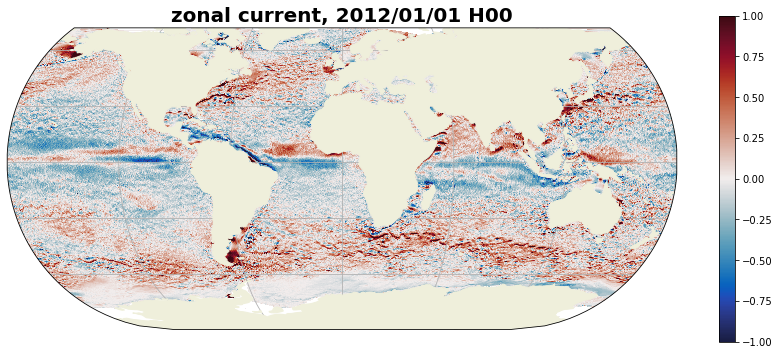

In [48]:
pl.plot_pretty(ds.SSU, vmin=-1., vmax=1., 
               cmap= pl.cm.balance, colorbar=True, colorbar_kwargs=dict(shrink=0.4),
               title="zonal current, "+str(SSU.time.dt.strftime("%Y/%m/%d H%H").values)
              )

### zoom 1

In [53]:
face = [2,]
ds = load_UV(dij=1, face=face, time="2012-07-01 00:00:00",)

{'fig': <Figure size 1080x1080 with 2 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'zonal current, 2012/07/01 H00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2aab4e974b80>}

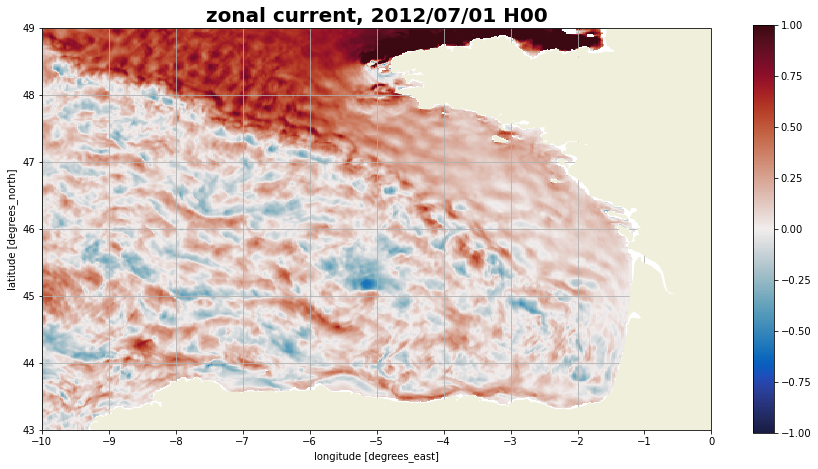

In [62]:
# Golf de Gascogne
region= dict(faces=face,
             extent=[-10, 0, 43, 49],
             projection= pl.ccrs.PlateCarree(), # pl._ortho_proj([-10, 0, 40, 50]),
             dticks=[1,1],
            )

pl.plot_pretty(ds.SSU, vmin=-1., vmax=1., 
               region=region,
               cmap= pl.cm.balance, colorbar=True, colorbar_kwargs=dict(shrink=0.5),
               title="zonal current, "+str(ds.time.dt.strftime("%Y/%m/%d H%H").values)
              )

{'fig': <Figure size 1080x1080 with 2 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'2012/07/01 H00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2aab54cc62b0>}

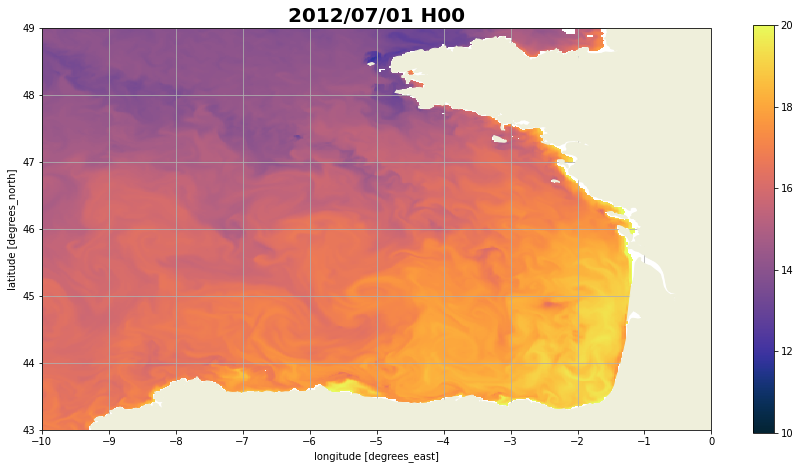

In [63]:
pl.plot_pretty(ds.SST, vmin=10., vmax=20., 
               region=region,
               cmap= pl.cm.thermal, colorbar=True, colorbar_kwargs=dict(shrink=0.5),
               title=str(ds.time.dt.strftime("%Y/%m/%d H%H").values)
              )

---

In [27]:
# add workers
w = cluster.scale_up(10)

In [15]:
# kill scheduler, workers
cluster.scheduler.close()
#cluster.stop_workers(cluster.jobs)

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:347]>

In [ ]:
# restart workers
client.restart()

In [ ]:
client